# Why ResNet50

**Strong Feature Extraction:** ResNet-50’s deep architecture captures intricate details in signatures, such as stroke patterns, texture, and pressure variations, essential for distinguishing real and forged signatures.

**Residual Connections:** Its residual blocks allow effective training of a deep network, ensuring good performance even on small or complex datasets by mitigating vanishing gradient issues.

**Adaptability:** It can be fine-tuned to focus on signature-specific features, making it suitable for tasks requiring high precision like signature verification.

**Efficiency and Scalability:** ResNet-50 balances depth and computational efficiency, making it practical for deployment in real-world signature verification systems.

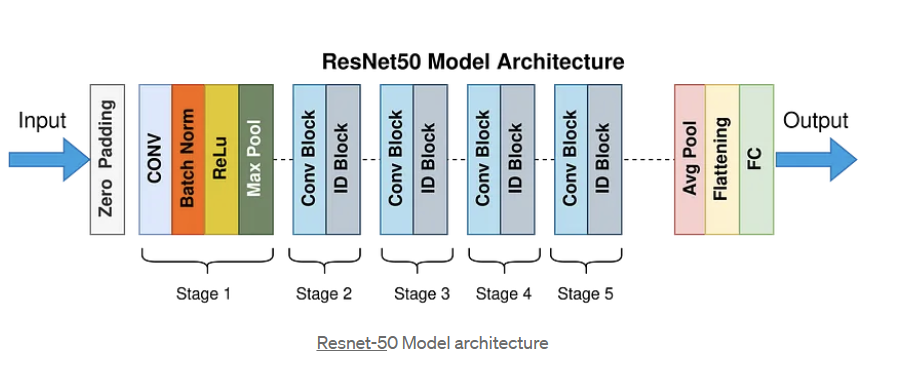
https://commons.wikimedia.org/wiki/File:ResNet50.png

# Imports

In [18]:
import kagglehub

In [19]:
import os
import cv2
import random

In [20]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load data

## helper functions

In [23]:
def load_images(folder_paths, folder_types, target_size=(128, 128), sample_count=5):

    images = []
    labels = []
    all_filenames = []

    for folder_path, folder_type in zip(folder_paths, folder_types):
        label = 1 if folder_type.lower() == 'real' else 0
        print(f"Loading images from: {folder_path}")

        sample_images = []  
        sample_titles = []  

        for idx, filename in enumerate(os.listdir(folder_path)):
            if filename.endswith(('.jpg', '.png')):
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img)
                img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
                img_array = img / 255.0 
                img_array = np.expand_dims(img_array, axis=-1)

                if len(sample_images) < sample_count:
                    sample_images.append(img_array)
                    sample_titles.append(f"{folder_type.capitalize()}: {filename}")

  
                images.append(img_array)
                labels.append(label)
                all_filenames.append(img_path)


        if sample_images:
            fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
            for ax, sample_img, title in zip(axes, sample_images, sample_titles):
                ax.imshow(sample_img.squeeze(), cmap='gray')  # Use `squeeze` to remove the extra dimension
                ax.set_title(title, fontsize=10)
                ax.axis('off')
            plt.tight_layout()
            plt.show()

    images = np.array(images)
    labels = np.array(labels)

    print(f"Total images loaded: {len(images)}")
    return images, labels

In [24]:
def show_samples(images, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')  
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

## loading and plotting

In [25]:
path = kagglehub.dataset_download("divyanshrai/handwritten-signatures")

In [26]:
forged_data_1 = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/"
real_data_1 ="/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/real/"
forged_data_2 = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/forge/"
real_data_2 ="/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/real/"
forged_data_3 = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3/forge/"
real_data_3 ="/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3/real/"
forged_data_4 = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4/forge/"
real_data_4 ="/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4/real1/"

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/


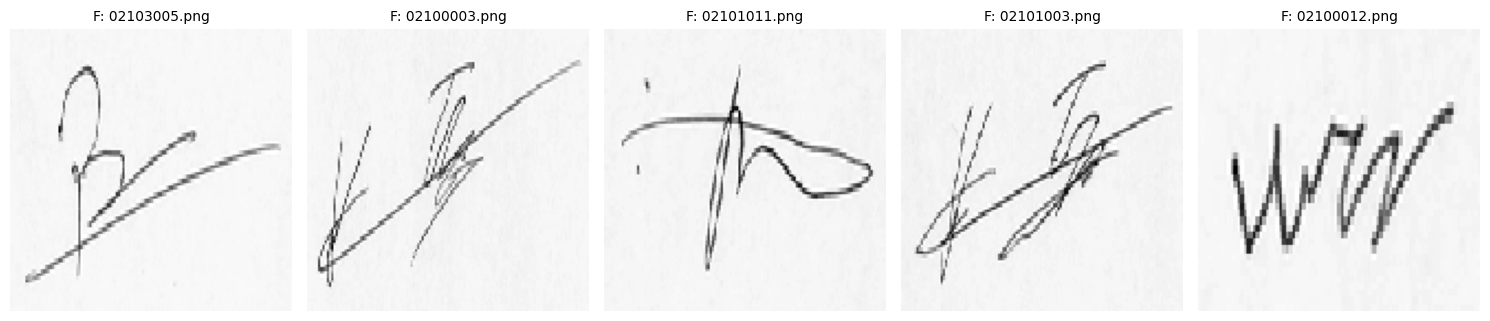

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/forge/


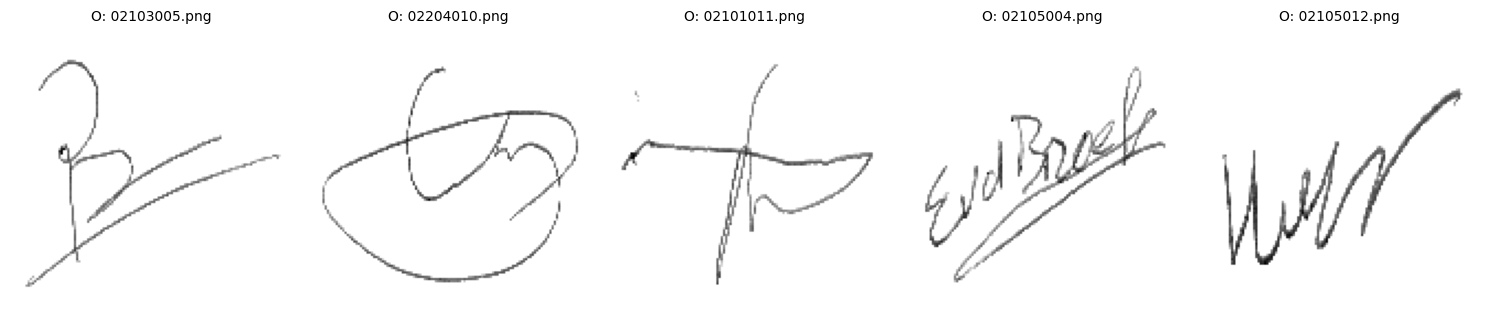

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3/forge/


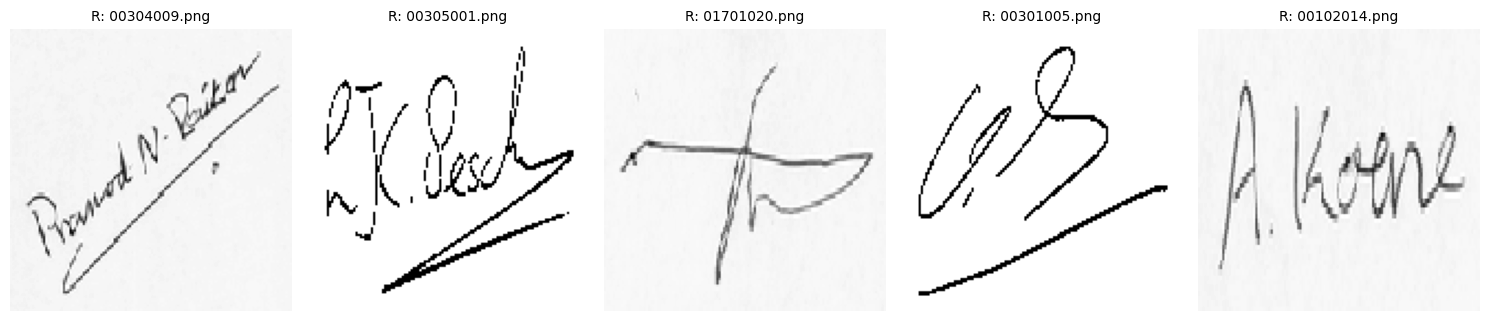

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4/forge/


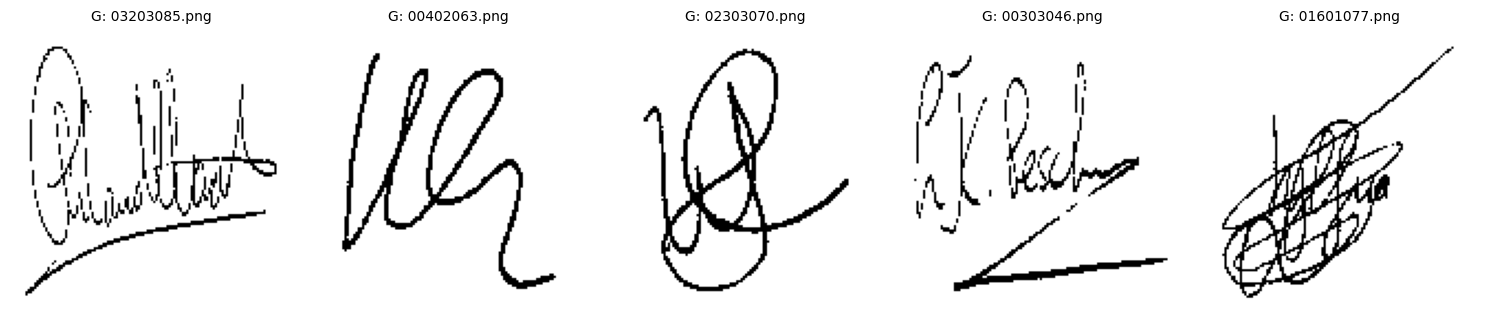

Total images loaded: 360
Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/real/


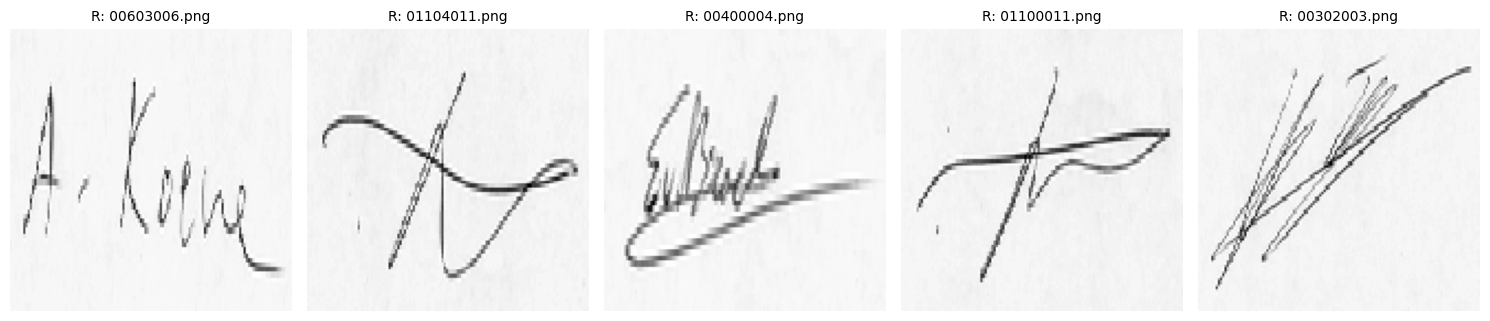

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/real/


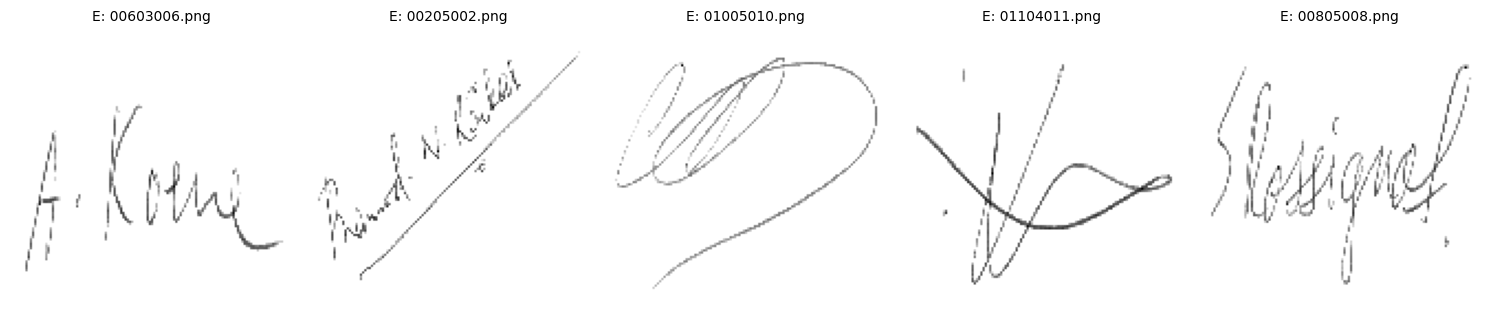

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3/real/


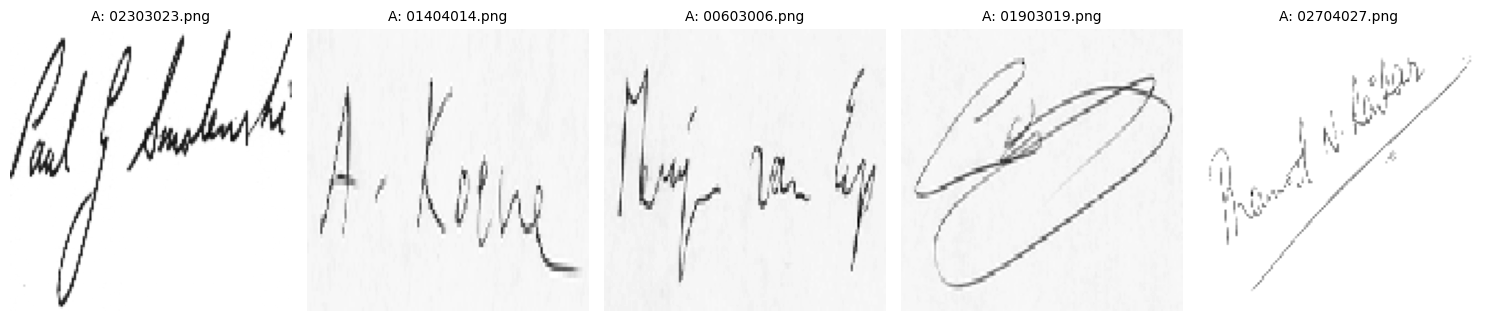

Loading images from: /kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4/real1/


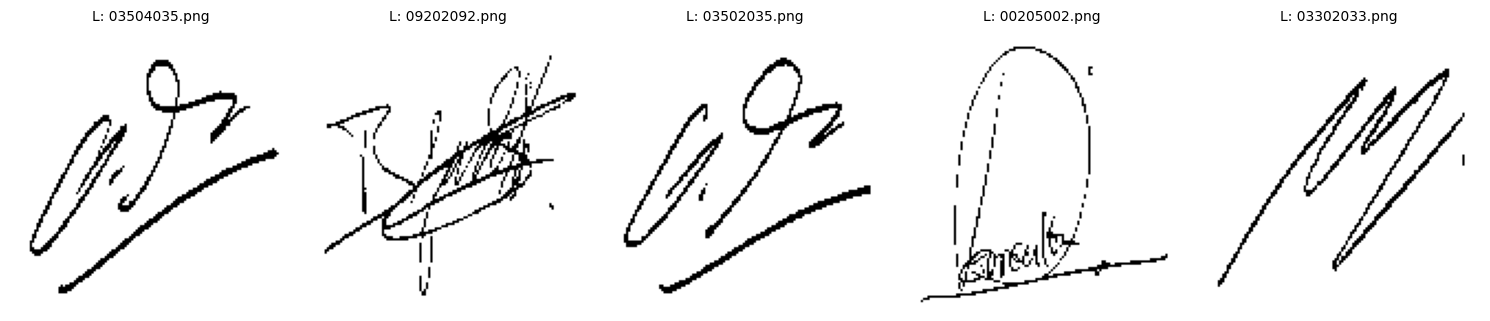

Total images loaded: 360


In [27]:
forged_list = [forged_data_1, forged_data_2,forged_data_3, forged_data_4]
real_list = [real_data_1,real_data_2,real_data_3,real_data_4]

forged_imgs, forged_label = load_images(forged_list,"forged")
real_imgs, real_label = load_images(real_list,"real")

# Prepare data

In [28]:
all_images = np.concatenate((forged_imgs, real_imgs), axis=0)
all_labels = np.concatenate((forged_label, real_label), axis=0)


all_images, all_labels = shuffle(all_images, all_labels, random_state=42)

In [29]:
len(forged_imgs)

360

In [30]:
all_labels = to_categorical(all_labels,num_classes = 2)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(504, 128, 128, 1)
(504, 2)
(216, 128, 128, 1)
(216, 2)


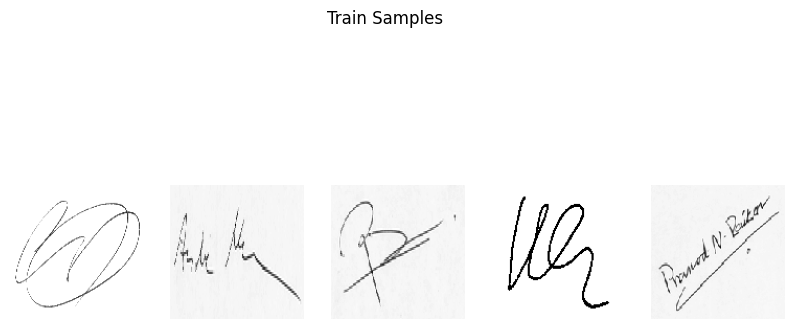

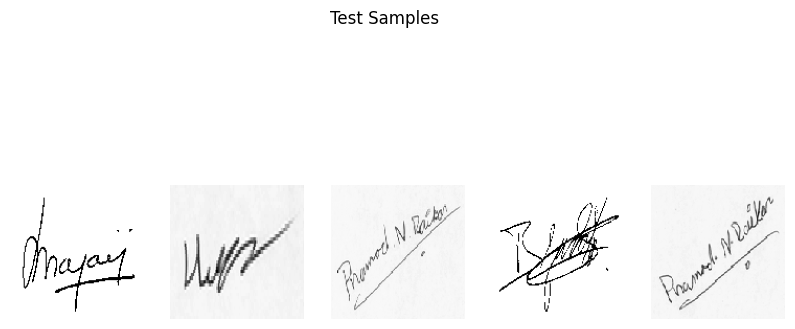

In [32]:
show_samples(x_train, "Train Samples")
show_samples(x_test, "Test Samples")

# Model

## helper functions

In [33]:
def plot_train(hist):
    history = hist.history

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    if 'accuracy' in history:  # Adjust for older versions with 'acc'
        axes[1].plot(history['accuracy'], label='Training Accuracy')
        axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy Over Epochs')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid()


    plt.tight_layout()
    plt.show()


## load my pretrained resnet model

In [34]:
loaded_model = tf.keras.models.load_model('/kaggle/input/resnet/keras/default/1/fr.h5')

## train

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


for layer in loaded_model.layers[:49]:
    layer.trainable = False


loaded_model.compile(optimizer=Adam(learning_rate=1e-6),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

hist = loaded_model.fit(
    x_train,y_train,
    epochs=10,
    validation_data=(x_test,y_test),
    callbacks=[ early_stopping],
    batch_size=32
)

Epoch 1/10


I0000 00:00:1734044763.152682     182 service.cc:145] XLA service 0x7bb18c002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734044763.152728     182 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734044763.152732     182 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/16 ━━━━━━━━━━━━━━━━━━━━ 9:34 38s/step - accuracy: 0.4375 - loss: 2.0499

I0000 00:00:1734044780.030563     182 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1734044780.060490     182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4748 - loss: 1.9593 - val_accuracy: 0.3935 - val_loss: 3.0989
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.4571 - loss: 1.7759 - val_accuracy: 0.4769 - val_loss: 2.2744
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.4762 - loss: 1.6131 - val_accuracy: 0.4398 - val_loss: 1.9216
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.4971 - loss: 1.2531 - val_accuracy: 0.4167 - val_loss: 1.6217
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5479 - loss: 1.0554 - val_accuracy: 0.5139 - val_loss: 1.0646
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5859 - loss: 0.8161 - val_accuracy: 0.6111 - val_loss: 0.6969
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6620 - loss: 0.7156 - val_accuracy: 0.7083 - val_loss: 0.5202
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6956 - loss: 0.6281 - val_accuracy: 0.8102 - val_lo

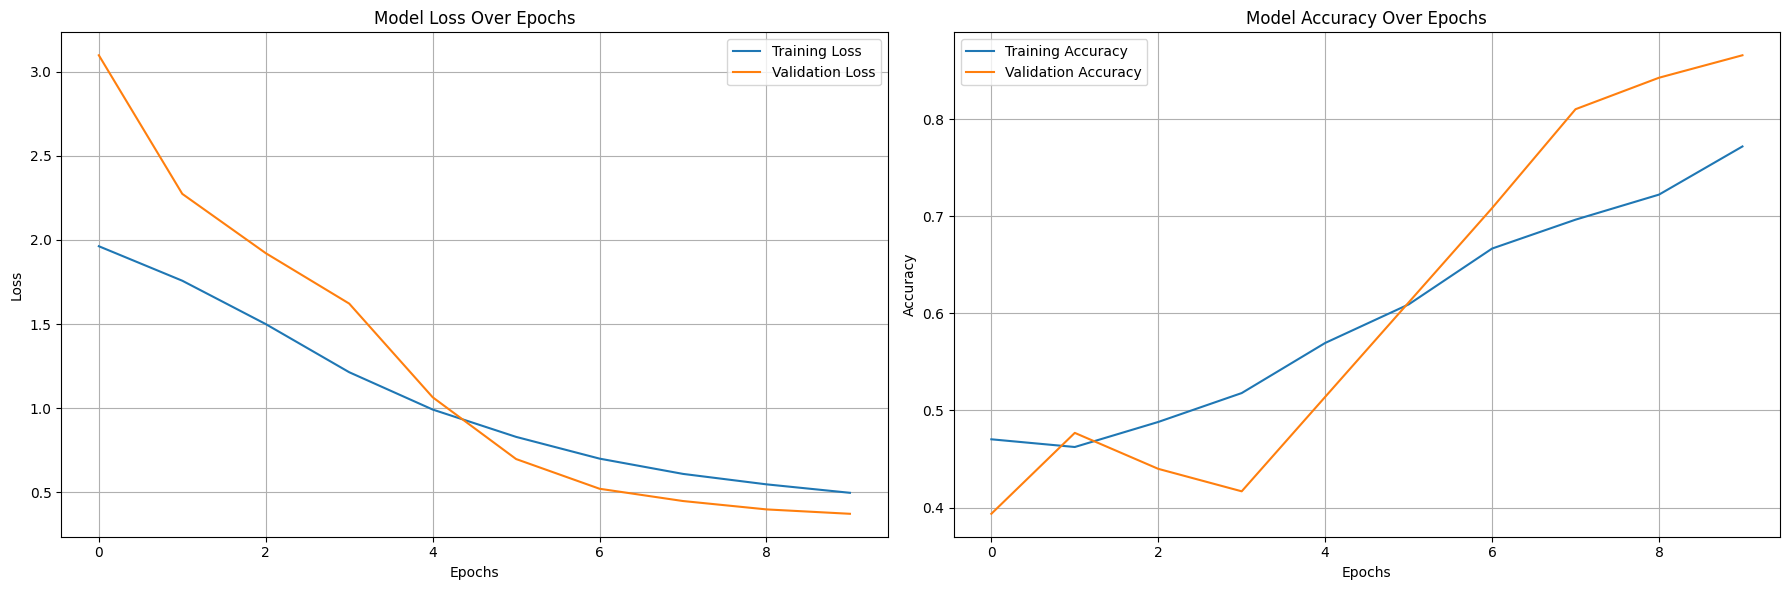

In [36]:
plot_train(hist)

## testing

In [37]:
loaded_model.evaluate(x_test,y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8383 - loss: 0.3727


[0.37127813696861267, 0.8657407164573669]

In [38]:
loaded_model.evaluate(x_train,y_train)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9134 - loss: 0.3150


[0.32703855633735657, 0.9067460298538208]